<a href="https://colab.research.google.com/github/wiatrak2/BScThesis/blob/master/DomainPredictorPlugging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading data

In [0]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('BScThesis/')

In [0]:
!pip3 install torch torchvision

In [62]:
!git clone https://github.com/wiatrak2/BScThesis

Cloning into 'BScThesis'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 212 (delta 16), reused 21 (delta 7), pack-reused 179
Receiving objects: 100% (212/212), 15.10 MiB | 16.74 MiB/s, done.
Resolving deltas: 100% (115/115), done.


In [0]:
from importlib import reload 

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
import torchvision
import torchvision.transforms as transforms

In [0]:
import matplotlib.pyplot as plt
import pickle
import sympy
from collections import defaultdict, namedtuple
import copy

In [0]:
from mnist_m import Mnist_M
from datasets_merge import Merge_Datasets
import models
import trainer
import domain_trainer
from test_model import test_model
import plots
import test
import plotly_plots

In [0]:
def convertMnist(img):
  img = img.squeeze().numpy()
  return torch.from_numpy(np.tile(img, (3,1,1)))

In [0]:
batch_size=128
num_workers=1

In [12]:
transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,)),
                           transforms.Lambda(convertMnist)
                       ])

train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                     transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)

test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True,
                                     transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)




Processing...
Done!


In [0]:
log_interval = 100

In [0]:
use_cuda = True
use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [0]:
lr = 0.001
momentum=0.9

In [0]:
mnist_m_transform = transforms.Compose([
                           transforms.Normalize(3*[0.1307], 3*[0.3081]),
                       ])
mnist_m_train = Mnist_M('drive/My Drive/BScThesis/keras_mnistm.pkl',
                        transform=mnist_m_transform)
mnist_m_test = Mnist_M('drive/My Drive/BScThesis/keras_mnistm.pkl',train=False,
                     transform=mnist_m_transform)
mnist_m_train_loader = torch.utils.data.DataLoader(mnist_m_train, 
                                                   batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)
mnist_m_test_loader = torch.utils.data.DataLoader(mnist_m_test,
                                                  batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)




In [0]:
Models = namedtuple('Models', ['model_f', 'model_c', 'model_d'])
Optims = namedtuple('Optims', ['optim_f', 'optim_c', 'optim_d'])
Criterions = namedtuple('Criterions', ['criterion', 'criterion_domain'])
Loaders = namedtuple('Loaders', ['train_loader', 'train_loader_domain',
                                'source_test_loader', 'target_test_loader',
                                'merged_test_loader'])

In [0]:
mnist_ext_train = Merge_Datasets([train_set, mnist_m_train])
mnist_ext_test = Merge_Datasets([test_set, mnist_m_test])
mnist_ext_train_loader = torch.utils.data.DataLoader(mnist_ext_train, 
                                                   batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)
mnist_ext_test_loader = torch.utils.data.DataLoader(mnist_ext_test, 
                                                   batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)





In [0]:
loaders = Loaders(train_loader, mnist_m_train_loader,
                 test_loader, mnist_m_test_loader, mnist_ext_test_loader)

In [0]:
criterion = F.nll_loss
criterion_domain = F.nll_loss

In [0]:
criterions = Criterions(criterion, criterion_domain)

In [0]:
epochs=16

# Functions

In [0]:
def test_domain(test_models, loaders, criterions, device, epochs):
  input_size = test_models.model_c.get_mtx().weight.size()[1]
  domain_pred = models.DomainPredictor(input_size=input_size).to(device)
  domain_optim = optim.Adam(domain_pred.parameters(), lr=lr)
  models_dom = Models(test_models.model_f, None, domain_pred)
  optims_dom = Optims(None, None, optim_d=domain_optim)
  mnist_domain_trainer = domain_trainer.DomainTrainer(models_dom, optims_dom, criterions, device, print_logs=False)
  domain_train_history = defaultdict(lambda:[])
  mnist_domain_trainer.train(epochs, loaders, None, train_history=domain_train_history)
  return domain_train_history

In [0]:
def get_next_models(train_models, device, freeze_model=True):
  if len(train_models.model_c.linears) == 0:
    return Models(None, None, None)
  model_c_f, model_c_c = train_models.model_c.split(1)
  model_c_f, model_c_c = model_c_f.to(device), model_c_c.to(device)
  new_model_f, input_size = models.extend_feature_extractor(train_models.model_f, model_c_f,
                                                           freeze_model=freeze_model)
  new_model_f=new_model_f.to(device)
  model_d = models.MnistDomain(input_size=input_size).to(device)
  return Models(new_model_f, model_c_c, model_d)

In [0]:
def domain_vainshing_research(train_models, optims, loaders, criterions,device,
                              epochs, freeze_model=True, print_test=True, extra_loss=None):
  trainers = []
  tests_histories = []
  domain_histories = []
  domain_gr_histories = []
  model_c_len = len(model_c.linears)
  while train_models.model_c is not None:
    domain_gr_histories.append(test_domain(train_models, loaders, criterions, device, epochs))
    if print_test:
      print('Model_c layers: {} Domain prediction on Feature Extractor after GR: {}'.format(
             model_c_len+1, domain_gr_histories[-1]['acc']))
    
    train_models = get_next_models(train_models, device, freeze_model=freeze_model)
    model_c_len -= 1
    if model_c_len < 0:
      break
    domain_histories.append(test_domain(train_models, loaders, criterions, device, epochs))    
    if print_test:
      print("Domain prediction on Class Predictor's first layer",
            domain_histories[-1]['acc'])    
    
    optim_f = optim.Adam(train_models.model_f.parameters(), lr=lr)
    optim_c = optim.Adam(train_models.model_c.parameters(), lr=lr)
    optim_d = optim.Adam(train_models.model_d.parameters(), lr=lr)
    optims = Optims(optim_f, optim_c, optim_d)    
    trainers.append(trainer.Trainer(train_models, optims, criterions, device, print_logs=False))
    tests_histories.append(defaultdict(lambda:[]))
    trainers[-1].train(epochs, loaders, extra_loss=extra_loss, test_history=tests_histories[-1])
    if print_test:
      print("Model_c layers: {} Model Accuracy with GR on Class Predictor's first layer: {}".format(
            model_c_len+1, tests_histories[-1]['target_acc']))

  return trainers, tests_histories, domain_histories, domain_gr_histories

# Model 320 / 320+100+100+100+10 / 320+100+2

In [0]:
mf = [320]
mc = [320, 100, 100, 100]
md = [320, 100]

In [0]:
_, model_c, model_d = models.get_models(mf, mc, md, use_gr=True, model_f_dropout=False)
model_f = models.MnistFeatureExtractor()
model_f, model_c, model_d = model_f.to(device), model_c.to(device), model_d.to(device)

In [0]:
optim_f = optim.Adam(model_f.parameters(), lr=lr)
optim_c = optim.Adam(model_c.parameters(), lr=lr)
optim_d = optim.Adam(model_d.parameters(), lr=lr)

In [0]:
train_models = Models(model_f, model_c, model_d)
optims = Optims(optim_f, optim_c, optim_d)

In [0]:
model_trainer = trainer.Trainer(train_models, optims, criterions, device, train_domain=True)

In [107]:
test_history = defaultdict(lambda:[])
model_trainer.train(epochs, loaders, test_history=test_history)

Train Epoch: 					1 [0/60000 (0%)]	Loss: 2.300637, lr: 0.00000 lambd: 0.00000
Train Epoch: 					1 [12800/60000 (21%)]	Loss: 0.969544, lr: 0.00000 lambd: 0.06657
Train Epoch: 					1 [25600/60000 (43%)]	Loss: 0.698947, lr: 0.00000 lambd: 0.13255
Train Epoch: 					1 [38400/60000 (64%)]	Loss: 0.391173, lr: 0.00000 lambd: 0.19738
Train Epoch: 					1 [51200/60000 (85%)]	Loss: 0.250406, lr: 0.00000 lambd: 0.26052

Target Domain Test set: Average loss: 1.2534, Accuracy: 5994/10000 (60%)
Source Domain Test set: Average loss: 0.1040, Accuracy: 9689/10000 (97%)
Domains predictor:  Accuracy: 17386/20000 (87%)

Train Epoch: 					2 [0/60000 (0%)]	Loss: 0.198904, lr: 0.00000 lambd: 0.30271
Train Epoch: 					2 [12800/60000 (21%)]	Loss: 0.371476, lr: 0.00000 lambd: 0.36198
Train Epoch: 					2 [25600/60000 (43%)]	Loss: 0.280737, lr: 0.00000 lambd: 0.41847
Train Epoch: 					2 [38400/60000 (64%)]	Loss: 0.224953, lr: 0.00000 lambd: 0.47189
Train Epoch: 					2 [51200/60000 (85%)]	Loss: 0.258644, lr: 0.00000

In [108]:
trainers, test_histories, domain_histories, domain_gr_histories = domain_vainshing_research(train_models, optims, loaders, criterions, device, epochs)

Model_c layers: 4 Domain prediction on Feature Extractor after GR: [82.915, 86.79, 88.29, 89.085, 90.31, 91.35, 91.99, 92.52, 93.335, 93.75, 93.43, 94.07, 94.43, 95.065, 95.275, 95.945]
Domain prediction on Class Predictor's first layer [72.44, 75.285, 77.0, 78.775, 79.785, 81.33, 82.545, 83.375, 84.36, 84.83, 85.65, 85.865, 86.47, 86.37, 87.02, 87.86]
Model_c layers: 3 Model Accuracy with GR on Class Predictor's first layer: [77.52, 78.22, 77.5, 77.89, 77.66, 78.06, 78.52, 78.22, 78.03, 78.76, 78.64, 78.2, 78.43, 78.16, 78.46, 78.74]
Model_c layers: 3 Domain prediction on Feature Extractor after GR: [66.015, 67.62, 68.03, 69.285, 69.07, 70.235, 70.805, 71.435, 71.35, 72.075, 73.075, 72.845, 73.275, 72.905, 73.73, 74.75]
Domain prediction on Class Predictor's first layer [65.275, 65.48, 67.99, 68.525, 69.535, 70.015, 70.175, 70.965, 71.58, 72.305, 72.215, 72.635, 72.74, 74.33, 74.615, 75.125]
Model_c layers: 2 Model Accuracy with GR on Class Predictor's first layer: [78.45, 78.67, 78.7

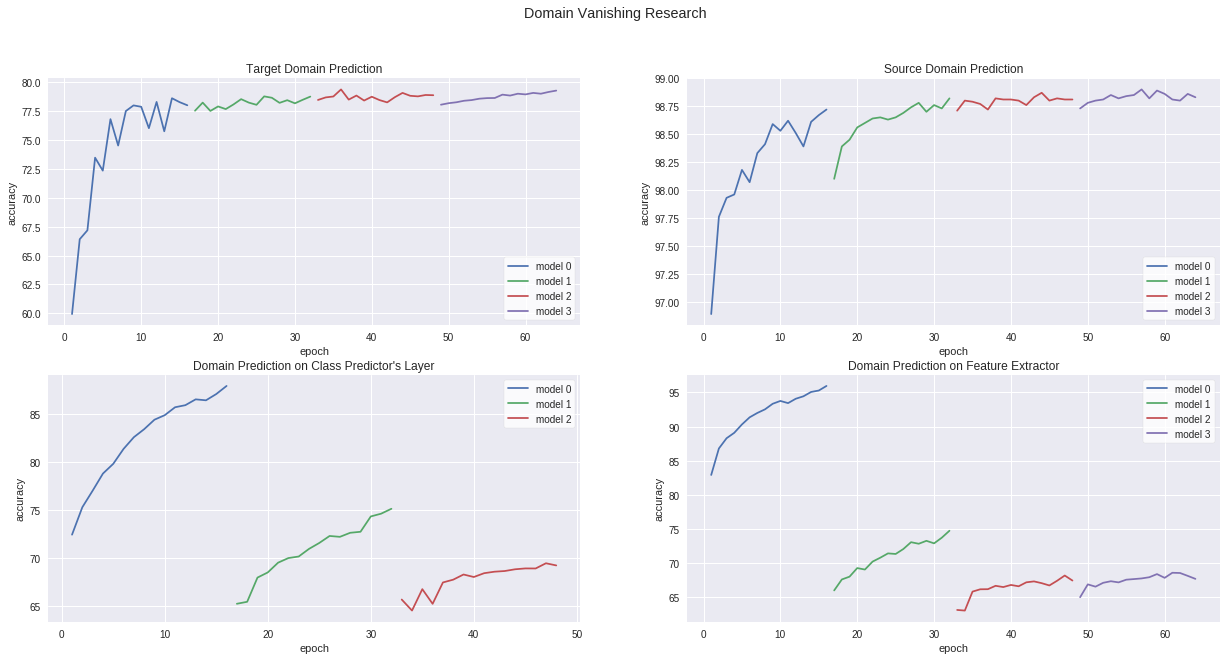

In [111]:
plots.plot_domain_vanishing([model_trainer] + trainers, [test_history] + test_histories, domain_histories, domain_gr_histories)

# Model 320 / 320+100+100+100+100+10 / 320+100+2

In [0]:
mf = [320]
mc = [320, 100, 100, 100, 100]
md = [320, 100]


In [0]:
_, model_c, model_d = models.get_models(mf, mc, md, use_gr=True, model_f_dropout=False)
model_f = models.MnistFeatureExtractor()
model_f, model_c, model_d = model_f.to(device), model_c.to(device), model_d.to(device)


In [0]:
optim_f = optim.Adam(model_f.parameters(), lr=lr)
optim_c = optim.Adam(model_c.parameters(), lr=lr)
optim_d = optim.Adam(model_d.parameters(), lr=lr)

In [0]:
train_models = Models(model_f, model_c, model_d)
optims = Optims(optim_f, optim_c, optim_d)


In [0]:
model_trainer2 = trainer.Trainer(train_models, optims, criterions, device, train_domain=True)


In [71]:
test_history2 = defaultdict(lambda:[])
model_trainer2.train(epochs, loaders, test_history=test_history2)


Train Epoch: 					1 [0/60000 (0%)]	Loss: 2.310709, lr: 0.00000 lambd: 0.00000
Train Epoch: 					1 [12800/60000 (21%)]	Loss: 1.470705, lr: 0.00000 lambd: 0.06657
Train Epoch: 					1 [25600/60000 (43%)]	Loss: 0.666572, lr: 0.00000 lambd: 0.13255
Train Epoch: 					1 [38400/60000 (64%)]	Loss: 0.671153, lr: 0.00000 lambd: 0.19738
Train Epoch: 					1 [51200/60000 (85%)]	Loss: 0.625428, lr: 0.00000 lambd: 0.26052

Target Domain Test set: Average loss: 1.4581, Accuracy: 5389/10000 (54%)
Source Domain Test set: Average loss: 0.1836, Accuracy: 9503/10000 (95%)
Domains predictor:  Accuracy: 14298/20000 (71%)

Train Epoch: 					2 [0/60000 (0%)]	Loss: 0.600796, lr: 0.00000 lambd: 0.30271
Train Epoch: 					2 [12800/60000 (21%)]	Loss: 0.507137, lr: 0.00000 lambd: 0.36198
Train Epoch: 					2 [25600/60000 (43%)]	Loss: 0.400059, lr: 0.00000 lambd: 0.41847
Train Epoch: 					2 [38400/60000 (64%)]	Loss: 0.241127, lr: 0.00000 lambd: 0.47189
Train Epoch: 					2 [51200/60000 (85%)]	Loss: 0.456178, lr: 0.00000

In [72]:
trainers2, test_histories2, domain_histories2, domain_gr_histories2 = domain_vainshing_research(train_models, optims, loaders, criterions, device, epochs)


Model_c layers: 5 Domain prediction on Feature Extractor after GR: [89.08, 90.76, 93.23, 93.845, 95.045, 94.835, 95.835, 96.17, 96.845, 96.895, 96.8, 97.395, 97.725, 97.705, 97.825, 98.08]
Domain prediction on Class Predictor's first layer [70.745, 74.73, 77.34, 79.53, 81.015, 82.735, 83.1, 84.615, 85.015, 85.37, 86.235, 86.85, 87.13, 87.87, 88.035, 88.12]
Model_c layers: 4 Model Accuracy with GR on Class Predictor's first layer: [71.63, 74.27, 74.21, 73.6, 73.61, 74.14, 74.28, 74.39, 74.85, 74.13, 74.45, 74.49, 74.43, 74.72, 74.55, 74.37]
Model_c layers: 4 Domain prediction on Feature Extractor after GR: [64.155, 65.0, 67.09, 67.37, 68.75, 68.805, 69.45, 70.8, 70.52, 71.2, 71.685, 72.445, 72.385, 73.0, 73.33, 73.83]
Domain prediction on Class Predictor's first layer [63.895, 65.755, 66.49, 67.21, 67.965, 68.37, 69.46, 70.315, 70.955, 71.455, 70.77, 71.975, 72.995, 73.32, 74.19, 73.815]
Model_c layers: 3 Model Accuracy with GR on Class Predictor's first layer: [73.33, 73.71, 74.02, 74.

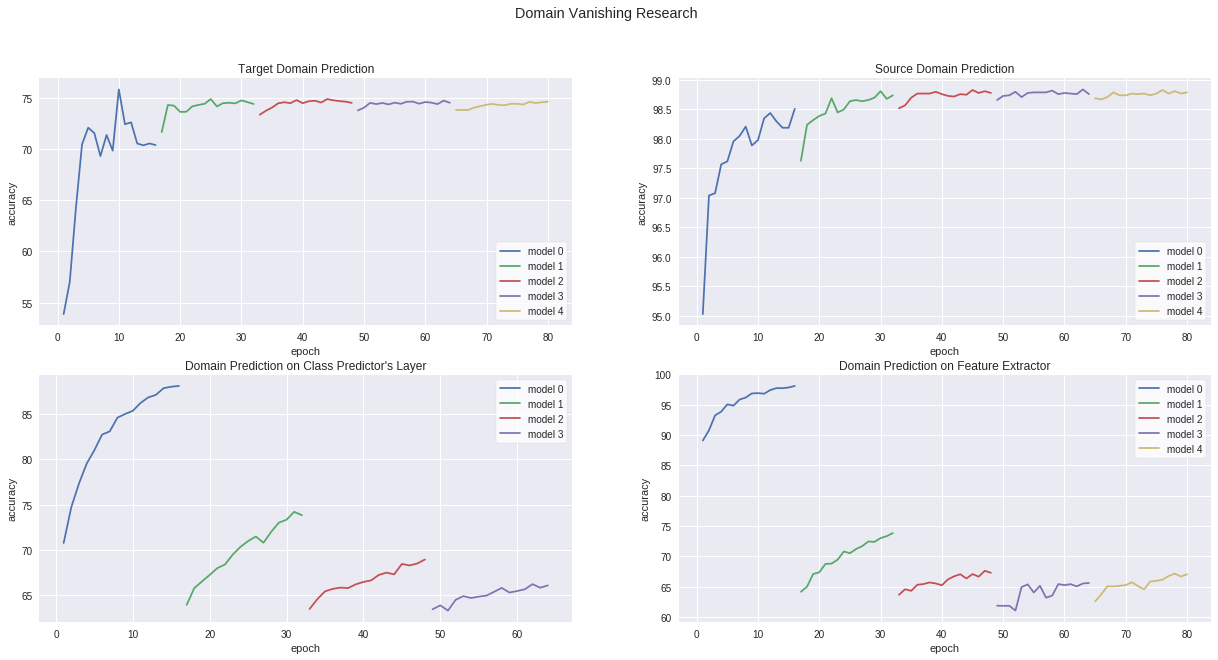

In [110]:
plots.plot_domain_vanishing([model_trainer2] + trainers2, [test_history2] + test_histories2, domain_histories2, domain_gr_histories2)

# Model 320+240 / 240+100+100+100+10 / 240+100+10

In [0]:
mf = [320, 240]
mc = [240, 100, 100, 100]
md = [240, 100]


In [0]:
model_f, model_c, model_d = models.get_models(mf, mc, md, use_gr=True, model_f_dropout=True)
model_f, model_c, model_d = model_f.to(device), model_c.to(device), model_d.to(device)

In [0]:
optim_f = optim.Adam(model_f.parameters(), lr=lr)
optim_c = optim.Adam(model_c.parameters(), lr=lr)
optim_d = optim.Adam(model_d.parameters(), lr=lr)

In [0]:
train_models = Models(model_f, model_c, model_d)
optims = Optims(optim_f, optim_c, optim_d)

In [0]:
model_trainer3 = trainer.Trainer(train_models, optims, criterions, device, train_domain=True)

In [79]:
test_history3 = defaultdict(lambda:[])
model_trainer3.train(16, loaders, test_history=test_history3)

Train Epoch: 					1 [0/60000 (0%)]	Loss: 2.308392, lr: 0.00000 lambd: 0.00000
Train Epoch: 					1 [12800/60000 (21%)]	Loss: 0.960444, lr: 0.00000 lambd: 0.06657
Train Epoch: 					1 [25600/60000 (43%)]	Loss: 0.467240, lr: 0.00000 lambd: 0.13255
Train Epoch: 					1 [38400/60000 (64%)]	Loss: 0.421583, lr: 0.00000 lambd: 0.19738
Train Epoch: 					1 [51200/60000 (85%)]	Loss: 0.349389, lr: 0.00000 lambd: 0.26052

Target Domain Test set: Average loss: 4.8605, Accuracy: 4502/10000 (45%)
Source Domain Test set: Average loss: 0.1337, Accuracy: 9650/10000 (96%)
Domains predictor:  Accuracy: 16052/20000 (80%)

Train Epoch: 					2 [0/60000 (0%)]	Loss: 0.470656, lr: 0.00000 lambd: 0.30271
Train Epoch: 					2 [12800/60000 (21%)]	Loss: 0.133185, lr: 0.00000 lambd: 0.36198
Train Epoch: 					2 [25600/60000 (43%)]	Loss: 0.361407, lr: 0.00000 lambd: 0.41847
Train Epoch: 					2 [38400/60000 (64%)]	Loss: 0.217491, lr: 0.00000 lambd: 0.47189
Train Epoch: 					2 [51200/60000 (85%)]	Loss: 0.267573, lr: 0.00000

In [80]:
trainers3, test_histories3, domain_histories3, domain_gr_histories3 = domain_vainshing_research(train_models, optims, loaders, criterions, device, epochs)

Model_c layers: 4 Domain prediction on Feature Extractor after GR: [76.85, 80.175, 83.22, 83.93, 85.675, 85.72, 86.05, 86.45, 86.895, 87.17, 88.225, 88.105, 88.115, 88.385, 88.965, 88.795]
Domain prediction on Class Predictor's first layer [70.71, 72.875, 75.53, 77.22, 79.0, 80.305, 81.51, 81.945, 83.2, 82.77, 83.635, 83.885, 84.61, 85.485, 85.615, 86.015]
Model_c layers: 3 Model Accuracy with GR on Class Predictor's first layer: [72.71, 72.73, 72.97, 73.01, 73.03, 73.06, 72.78, 72.83, 72.94, 72.85, 72.87, 73.03, 72.73, 72.99, 72.76, 72.68]
Model_c layers: 3 Domain prediction on Feature Extractor after GR: [63.42, 64.98, 68.8, 67.775, 66.445, 69.5, 70.14, 68.78, 69.115, 70.665, 71.04, 68.42, 70.205, 72.33, 69.905, 73.145]
Domain prediction on Class Predictor's first layer [63.555, 64.705, 66.865, 67.925, 66.895, 69.075, 69.025, 70.11, 70.435, 71.59, 70.62, 72.105, 71.5, 72.355, 72.76, 72.485]
Model_c layers: 2 Model Accuracy with GR on Class Predictor's first layer: [72.78, 72.83, 72.7

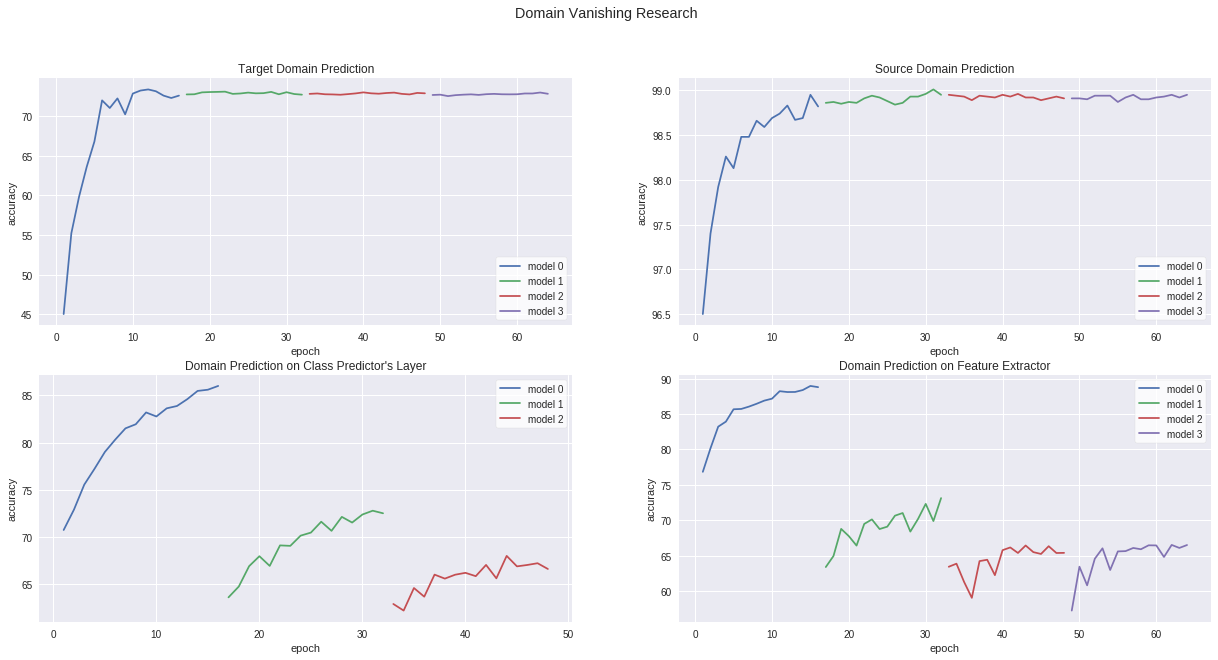

In [112]:
plots.plot_domain_vanishing([model_trainer3] + trainers3, [test_history3] + test_histories3, domain_histories3, domain_gr_histories3)

# Model 320 / 320+200+100 / 320+100

In [0]:
mf = [320]
mc = [320, 200, 100]
md = [320, 100]

In [0]:
_, model_c, model_d = models.get_models(mf, mc, md, use_gr=True, model_f_dropout=False)
model_f = models.MnistFeatureExtractor()
model_f, model_c, model_d = model_f.to(device), model_c.to(device), model_d.to(device)

In [0]:
optim_f = optim.Adam(model_f.parameters(), lr=lr)
optim_c = optim.Adam(model_c.parameters(), lr=lr)
optim_d = optim.Adam(model_d.parameters(), lr=lr)

In [0]:
train_models = Models(model_f, model_c, model_d)
optims = Optims(optim_f, optim_c, optim_d)

In [0]:
model_trainer4 = trainer.Trainer(train_models, optims, criterions, device, train_domain=True)

In [28]:
test_history4 = defaultdict(lambda:[])
model_trainer4.train(16, loaders, test_history=test_history4)

Train Epoch: 					1 [0/60000 (0%)]	Loss: 2.312484, lr: 0.00000 lambd: 0.00000
Train Epoch: 					1 [12800/60000 (21%)]	Loss: 0.416553, lr: 0.00000 lambd: 0.06657
Train Epoch: 					1 [25600/60000 (43%)]	Loss: 0.370144, lr: 0.00000 lambd: 0.13255
Train Epoch: 					1 [38400/60000 (64%)]	Loss: 0.260798, lr: 0.00000 lambd: 0.19738
Train Epoch: 					1 [51200/60000 (85%)]	Loss: 0.279328, lr: 0.00000 lambd: 0.26052

Target Domain Test set: Average loss: 1.1563, Accuracy: 6355/10000 (64%)
Source Domain Test set: Average loss: 0.0886, Accuracy: 9740/10000 (97%)
Domains predictor:  Accuracy: 17540/20000 (88%)

Train Epoch: 					2 [0/60000 (0%)]	Loss: 0.065126, lr: 0.00000 lambd: 0.30271
Train Epoch: 					2 [12800/60000 (21%)]	Loss: 0.166259, lr: 0.00000 lambd: 0.36198
Train Epoch: 					2 [25600/60000 (43%)]	Loss: 0.392853, lr: 0.00000 lambd: 0.41847
Train Epoch: 					2 [38400/60000 (64%)]	Loss: 0.259176, lr: 0.00000 lambd: 0.47189
Train Epoch: 					2 [51200/60000 (85%)]	Loss: 0.167441, lr: 0.00000

In [33]:
trainers4, test_histories4, domain_histories4, domain_gr_histories4 = domain_vainshing_research(train_models, optims, loaders, criterions, device, epochs)

Model_c layers: 3 Domain prediction on Feature Extractor after GR: [81.12, 84.795, 86.45, 86.89, 88.21, 89.74, 90.64, 90.37, 91.165, 91.44, 92.635, 92.65, 92.795, 93.68, 93.78, 93.95]
Domain prediction on Class Predictor's first layer [72.665, 75.96, 78.45, 80.81, 82.69, 83.555, 84.95, 85.53, 85.84, 87.315, 87.115, 87.895, 88.515, 88.66, 88.425, 89.685]
Model_c layers: 2 Model Accuracy with GR on Class Predictor's first layer: [78.68, 79.88, 80.08, 80.19, 79.88, 80.14, 80.49, 80.32, 79.87, 80.34, 80.6, 80.29, 80.31, 80.42, 80.29, 80.09]
Model_c layers: 2 Domain prediction on Feature Extractor after GR: [68.335, 69.645, 70.585, 72.91, 73.8, 73.55, 73.88, 74.715, 75.535, 76.685, 76.46, 76.81, 78.04, 77.545, 78.195, 78.275]
Domain prediction on Class Predictor's first layer [64.84, 68.125, 68.535, 70.24, 71.21, 73.395, 73.665, 74.245, 75.98, 75.74, 76.45, 76.495, 76.505, 77.27, 77.2, 77.425]
Model_c layers: 1 Model Accuracy with GR on Class Predictor's first layer: [80.24, 79.76, 79.88, 8

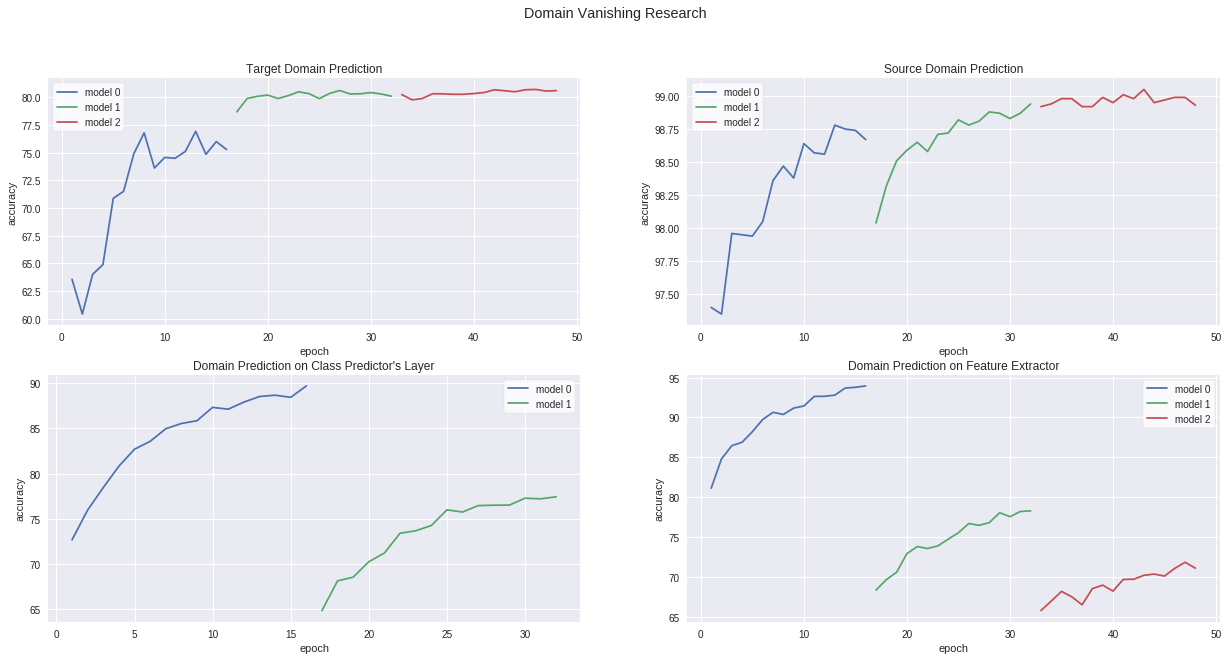

In [143]:
plots.plot_domain_vanishing([model_trainer4] + trainers4, [test_history4] + test_histories4, domain_histories4, domain_gr_histories4)

# Model 320 / 320+50 / 320+50

In [0]:
mf = [320]
mc = [320, 50]
md = [320, 50]

In [0]:
_, model_c, model_d = models.get_models(mf, mc, md, use_gr=True, model_f_dropout=True)
model_f = models.MnistFeatureExtractor()
model_f, model_c, model_d = model_f.to(device), model_c.to(device), model_d.to(device)

In [0]:
optim_f = optim.Adam(model_f.parameters(), lr=lr)
optim_c = optim.Adam(model_c.parameters(), lr=lr)
optim_d = optim.Adam(model_d.parameters(), lr=lr)

In [0]:
train_models = Models(model_f, model_c, model_d)
optims = Optims(optim_f, optim_c, optim_d)

In [0]:
model_trainer5 = trainer.Trainer(train_models, optims, criterions, device, train_domain=True)

In [93]:
test_history5 = defaultdict(lambda:[])
model_trainer5.train(epochs, loaders, test_history=test_history4)

Train Epoch: 					1 [0/60000 (0%)]	Loss: 2.309194, lr: 0.00000 lambd: 0.00000
Train Epoch: 					1 [12800/60000 (21%)]	Loss: 0.591261, lr: 0.00000 lambd: 0.06657
Train Epoch: 					1 [25600/60000 (43%)]	Loss: 0.332643, lr: 0.00000 lambd: 0.13255
Train Epoch: 					1 [38400/60000 (64%)]	Loss: 0.457599, lr: 0.00000 lambd: 0.19738
Train Epoch: 					1 [51200/60000 (85%)]	Loss: 0.236759, lr: 0.00000 lambd: 0.26052

Target Domain Test set: Average loss: 1.4117, Accuracy: 5782/10000 (58%)
Source Domain Test set: Average loss: 0.0879, Accuracy: 9732/10000 (97%)
Domains predictor:  Accuracy: 17870/20000 (89%)

Train Epoch: 					2 [0/60000 (0%)]	Loss: 0.220000, lr: 0.00000 lambd: 0.30271
Train Epoch: 					2 [12800/60000 (21%)]	Loss: 0.362950, lr: 0.00000 lambd: 0.36198
Train Epoch: 					2 [25600/60000 (43%)]	Loss: 0.273503, lr: 0.00000 lambd: 0.41847
Train Epoch: 					2 [38400/60000 (64%)]	Loss: 0.271031, lr: 0.00000 lambd: 0.47189
Train Epoch: 					2 [51200/60000 (85%)]	Loss: 0.342332, lr: 0.00000

In [0]:
adam_models = copy.deepcopy(train_models)

In [95]:
trainers5, test_histories5, domain_histories5, domain_gr_histories5 = domain_vainshing_research(train_models, optims, loaders, criterions, device, epochs)

Model_c layers: 2 Domain prediction on Feature Extractor after GR: [79.565, 84.3, 86.2, 86.9, 88.79, 89.315, 90.755, 91.04, 91.65, 92.165, 92.62, 92.775, 93.485, 93.235, 94.085, 93.945]
Domain prediction on Class Predictor's first layer [64.045, 65.625, 68.145, 69.88, 71.455, 72.405, 74.13, 75.315, 75.505, 75.635, 76.715, 77.1, 77.44, 78.03, 77.94, 77.81]
Model_c layers: 1 Model Accuracy with GR on Class Predictor's first layer: [79.42, 80.16, 79.96, 79.98, 80.3, 80.09, 80.04, 79.89, 80.05, 80.29, 79.98, 80.66, 80.28, 80.04, 80.34, 80.47]
Model_c layers: 1 Domain prediction on Feature Extractor after GR: [63.24, 66.055, 66.715, 66.425, 67.34, 67.25, 68.885, 69.11, 69.65, 69.96, 70.12, 70.615, 69.93, 71.215, 70.9, 71.66]


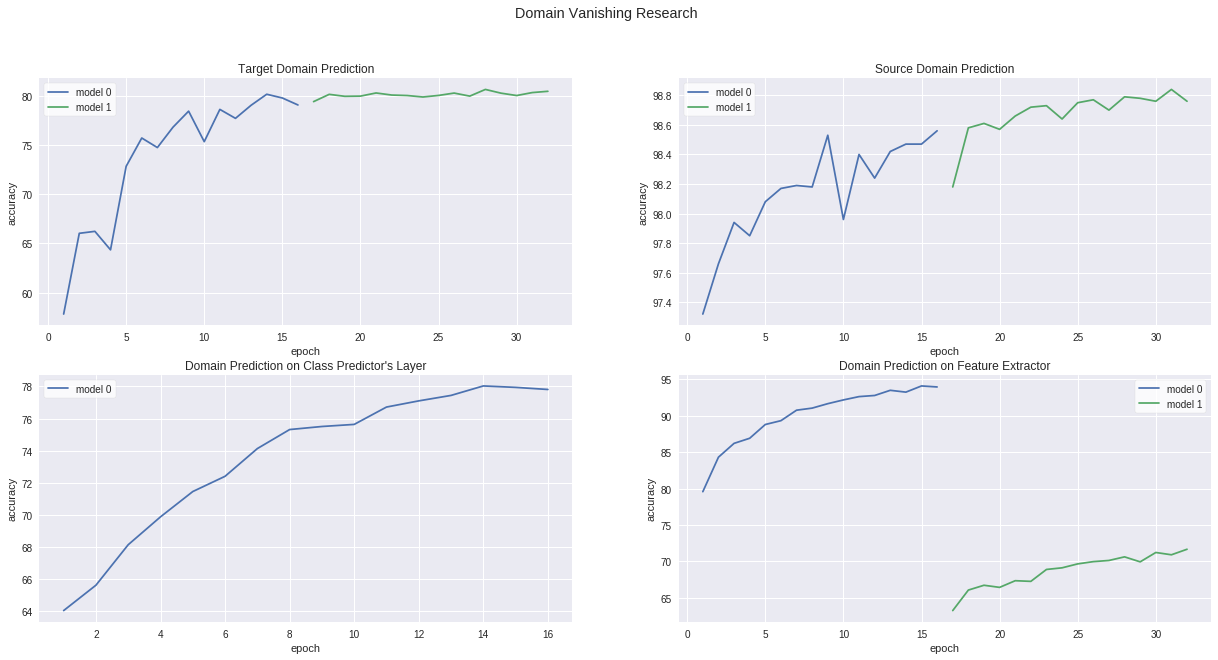

In [141]:
plots.plot_domain_vanishing([model_trainer5] + trainers5, [test_history5] + test_histories5, domain_histories5, domain_gr_histories5)

# Model 320 / 320+50 / 320+50 + Minimize dot product

In [0]:
def mtx_dot(model_f, model_c, model_d, *args):
  return torch.mean(torch.pow(torch.mm(model_c.get_mtx().weight, torch.transpose(model_d.get_mtx().weight, 0, 1)), 2))

In [100]:
trainers6, test_histories6, domain_histories6, domain_gr_histories6 = domain_vainshing_research(adam_models, optims, loaders, criterions, device,
                                                                                                epochs, extra_loss=mtx_dot)

Model_c layers: 2 Domain prediction on Feature Extractor after GR: [78.885, 83.86, 85.81, 87.275, 88.385, 89.895, 90.52, 91.27, 90.59, 92.38, 92.58, 93.095, 93.44, 93.68, 94.04, 94.445]
Domain prediction on Class Predictor's first layer [61.545, 66.055, 69.1, 71.015, 72.485, 73.765, 75.09, 75.915, 76.875, 77.065, 77.62, 78.43, 78.835, 78.99, 79.49, 79.935]
Model_c layers: 1 Model Accuracy with GR on Class Predictor's first layer: [79.88, 79.96, 79.53, 80.24, 80.23, 79.46, 80.05, 79.99, 80.67, 80.26, 80.22, 80.68, 80.3, 80.02, 80.05, 79.68]
Model_c layers: 1 Domain prediction on Feature Extractor after GR: [62.51, 63.745, 66.38, 67.7, 67.81, 68.345, 68.855, 69.285, 69.25, 69.91, 70.19, 70.525, 71.165, 70.6, 72.05, 71.65]


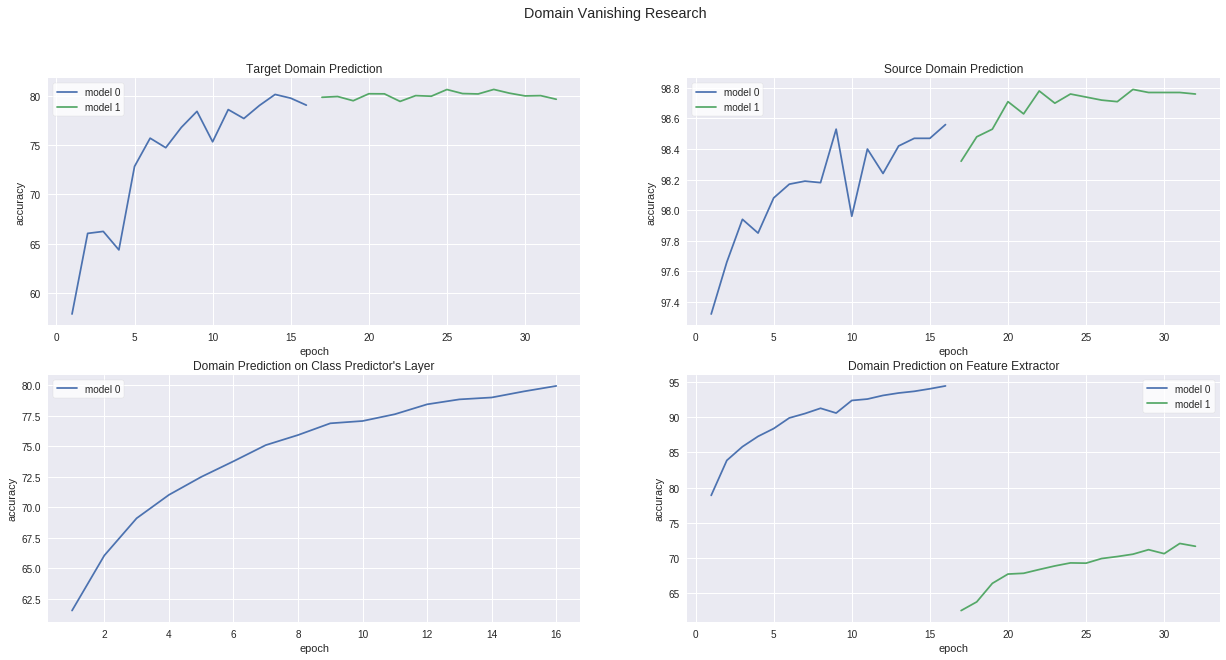

In [140]:
plots.plot_domain_vanishing([model_trainer5] + trainers6, [test_history5] + test_histories6, domain_histories6, domain_gr_histories6)

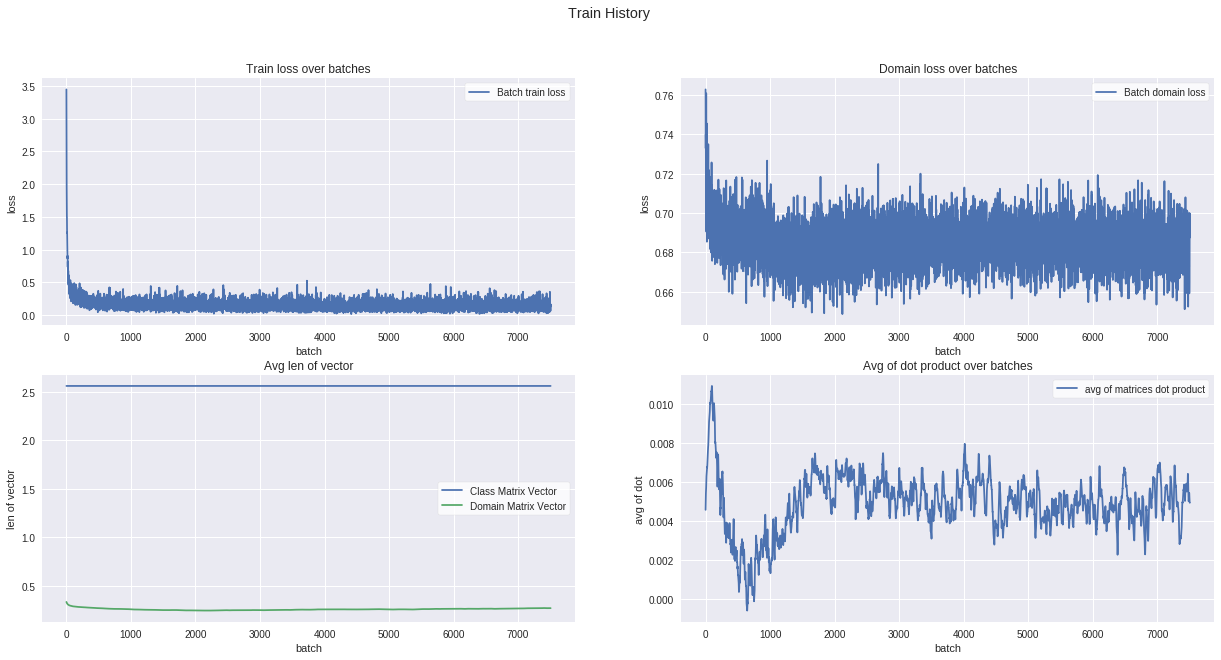

In [157]:
plots.plot_training(trainers6[-1].train_history)

# Training plots

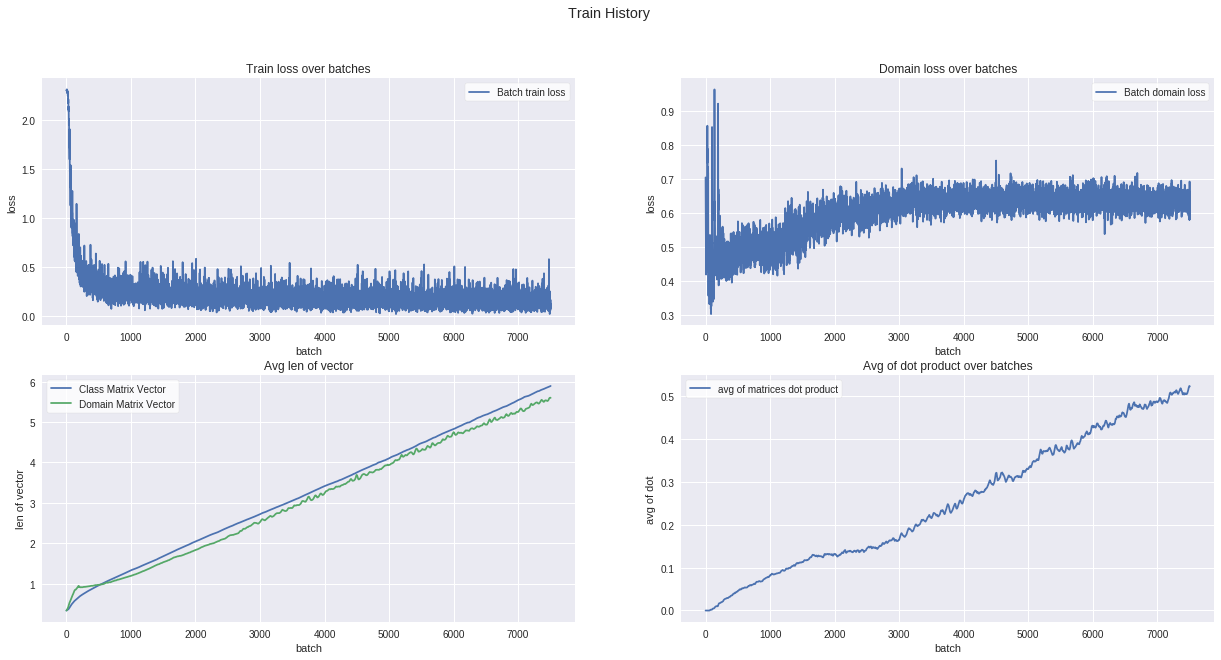

In [145]:
plots.plot_training(model_trainer.train_history)

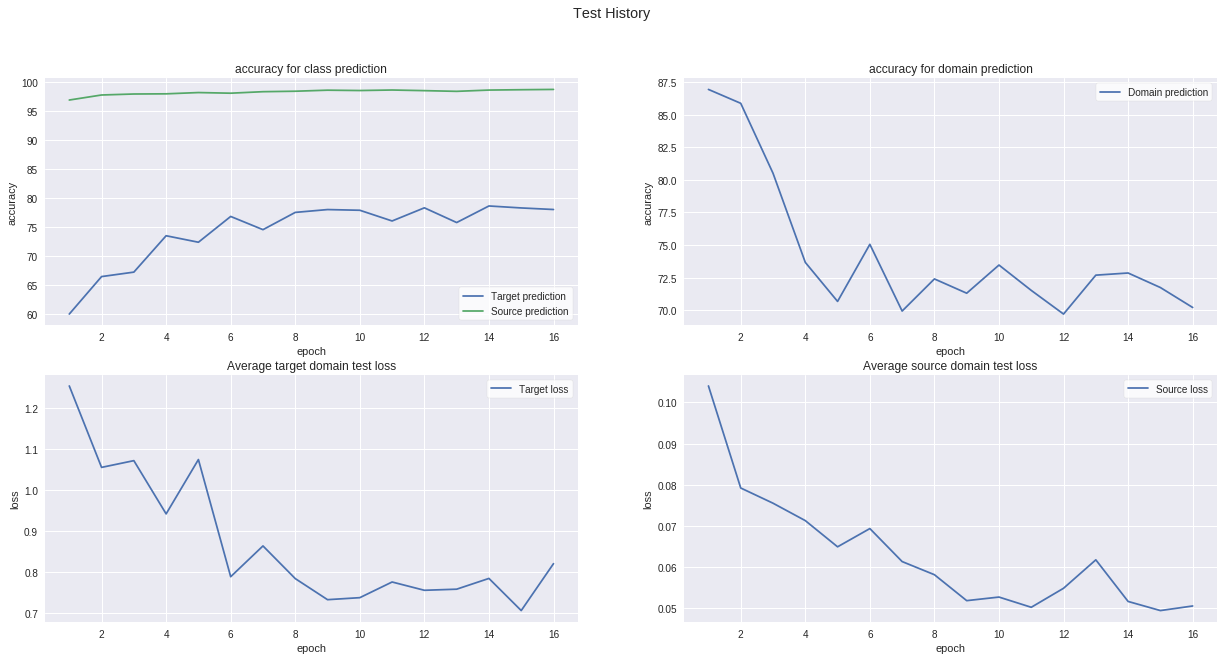

In [146]:
plots.plot_test(test_history)

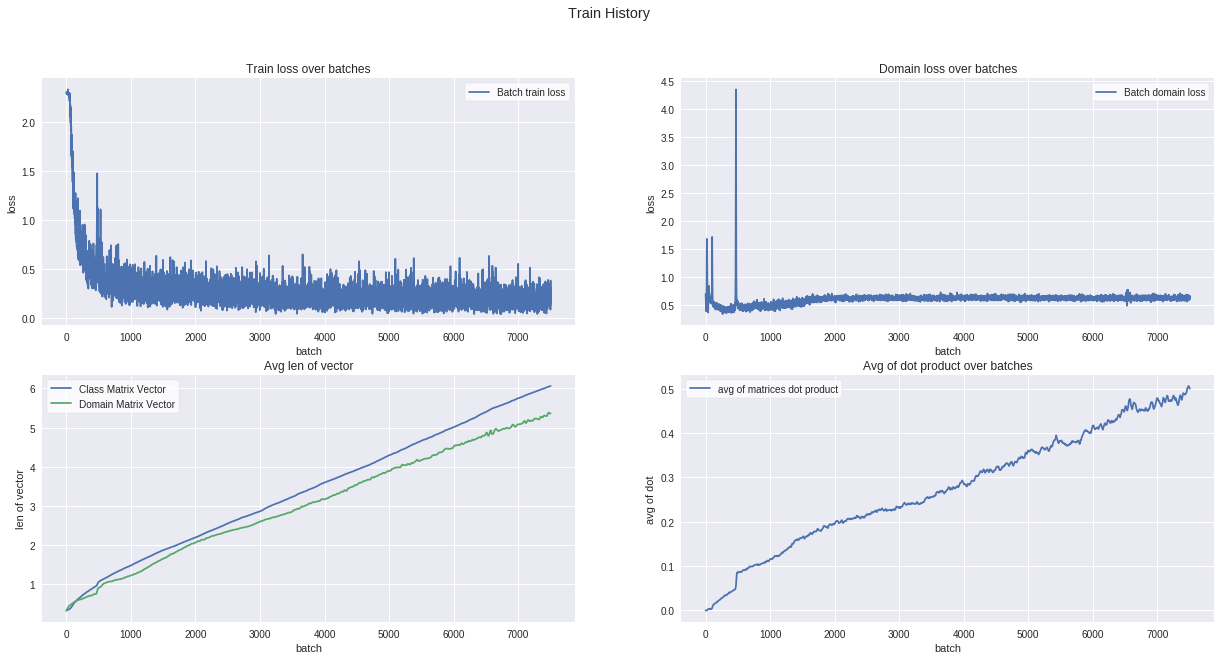

In [147]:
plots.plot_training(model_trainer2.train_history)

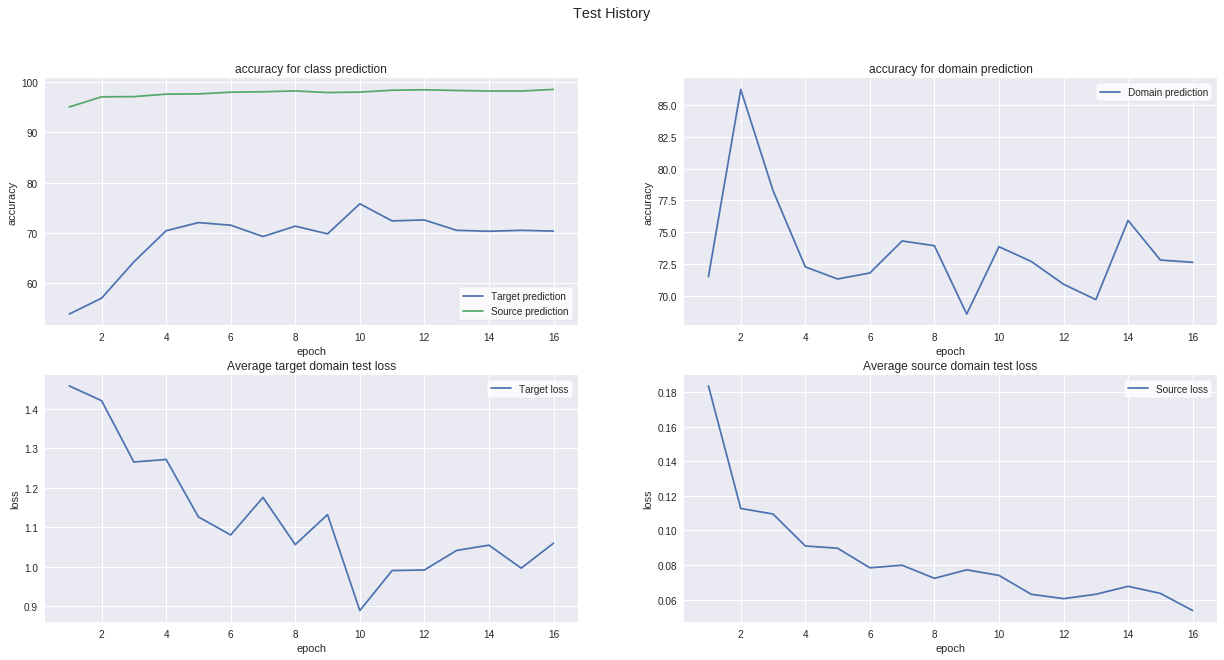

In [148]:
plots.plot_test(test_history2)

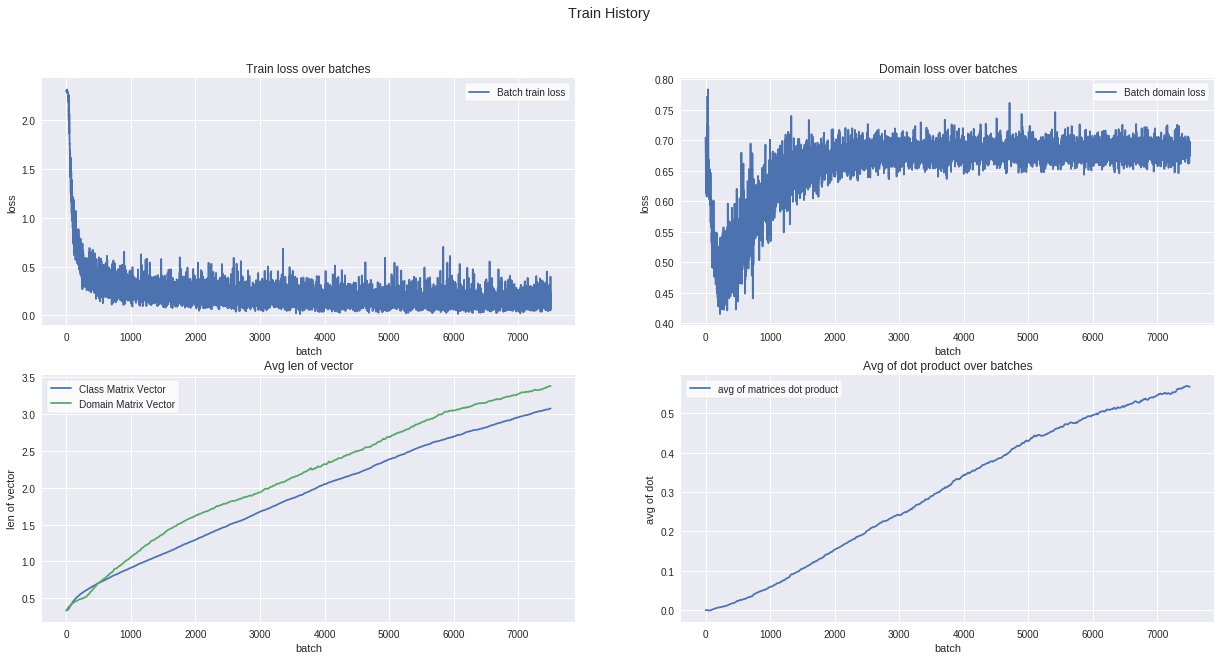

In [149]:
plots.plot_training(model_trainer3.train_history)

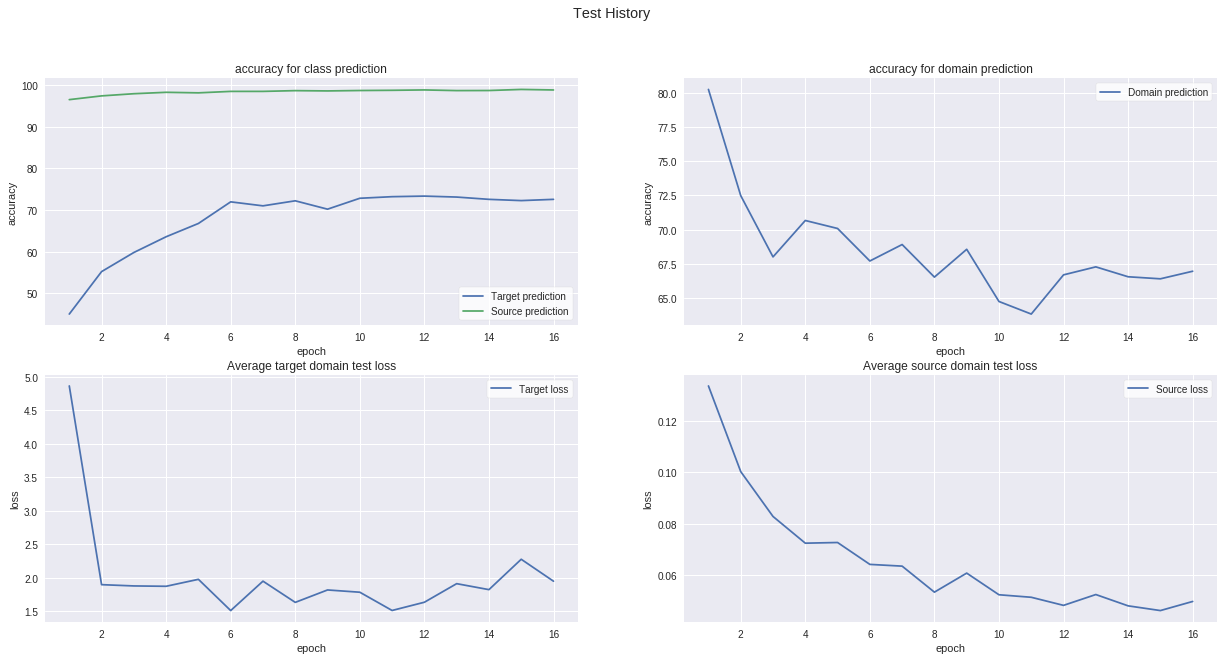

In [150]:
plots.plot_test(test_history3)

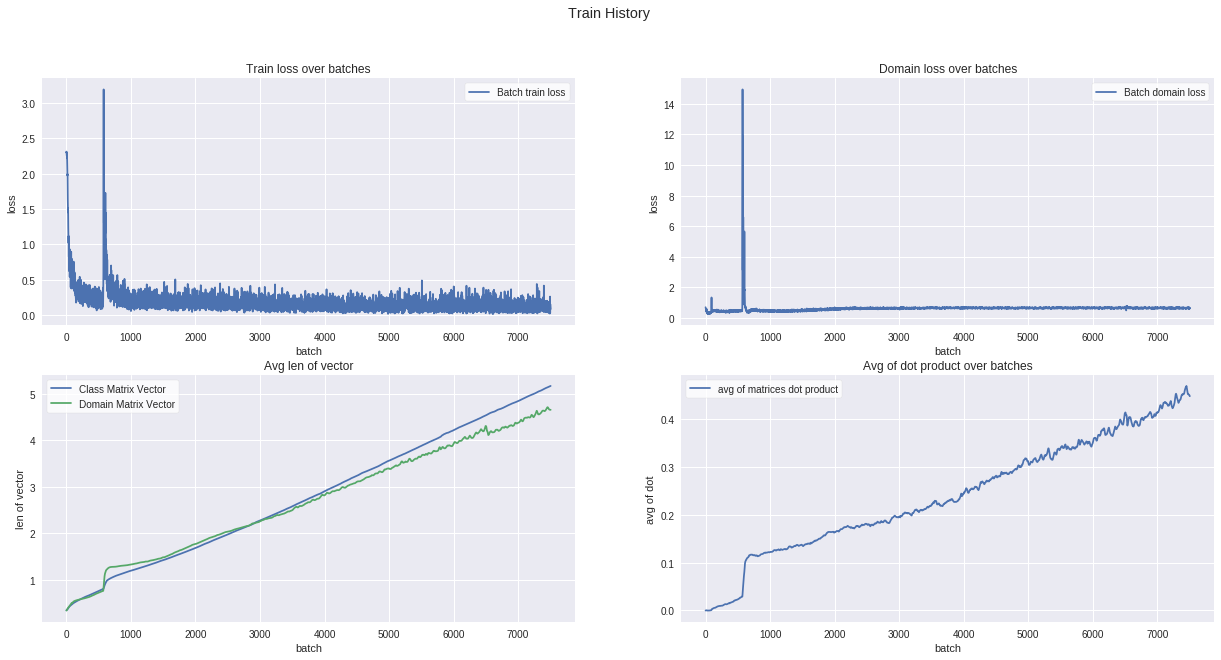

In [151]:
plots.plot_training(model_trainer4.train_history)

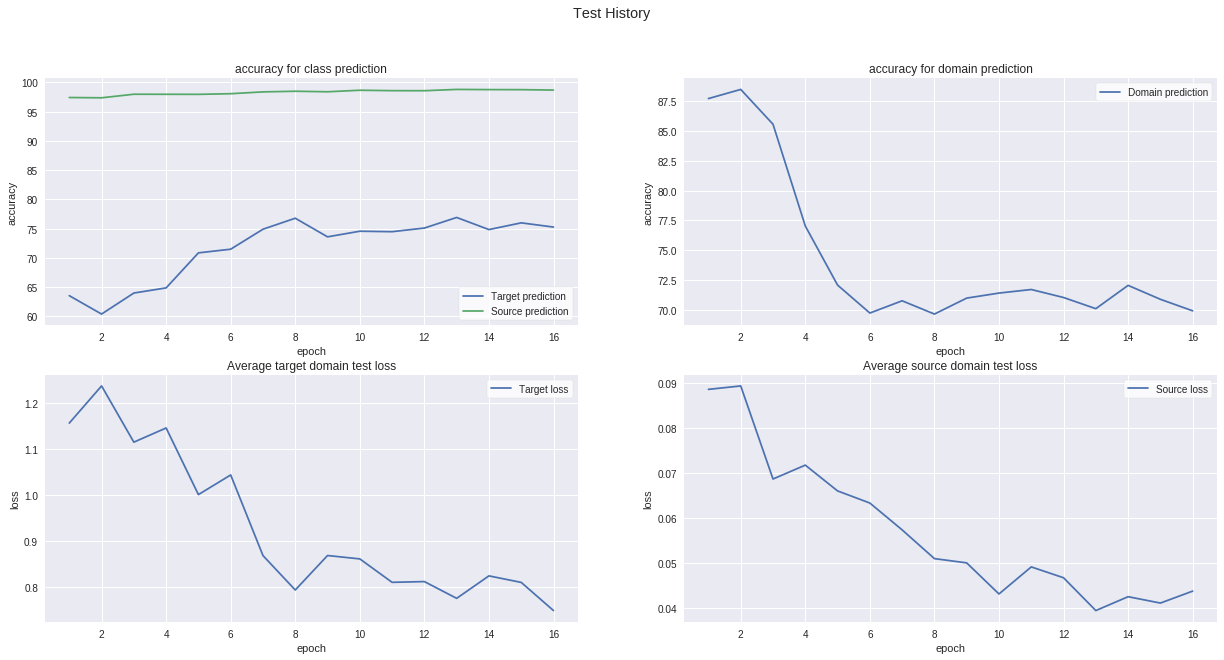

In [152]:
plots.plot_test(test_history4)

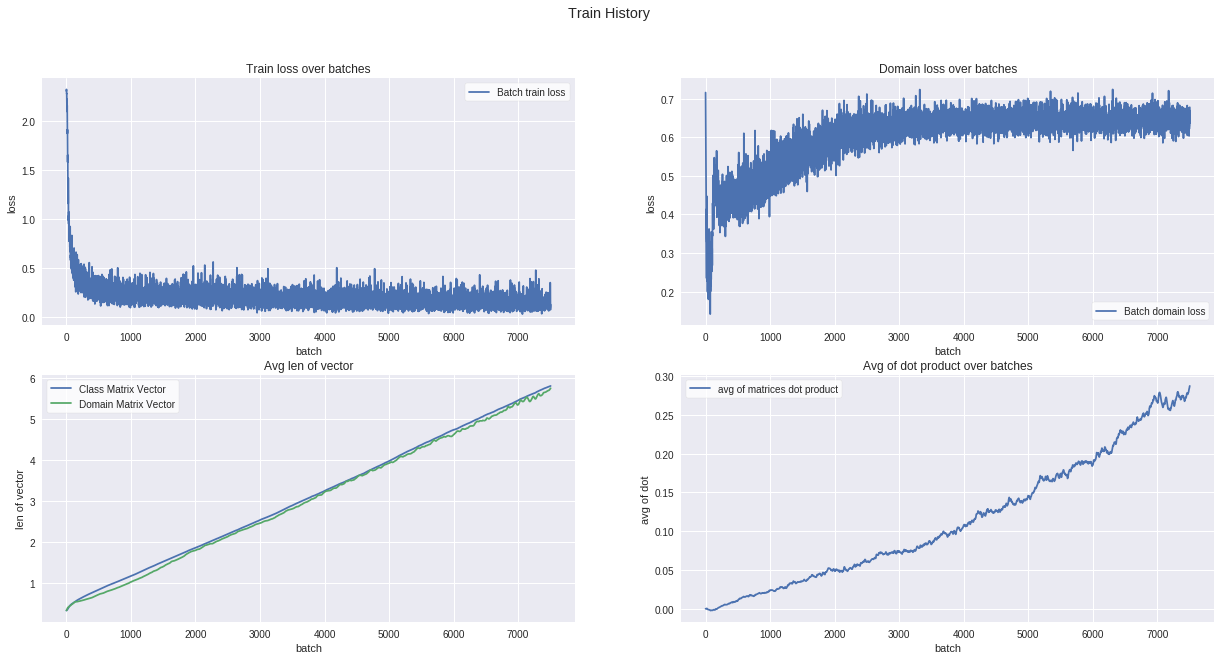

In [153]:
plots.plot_training(model_trainer5.train_history)

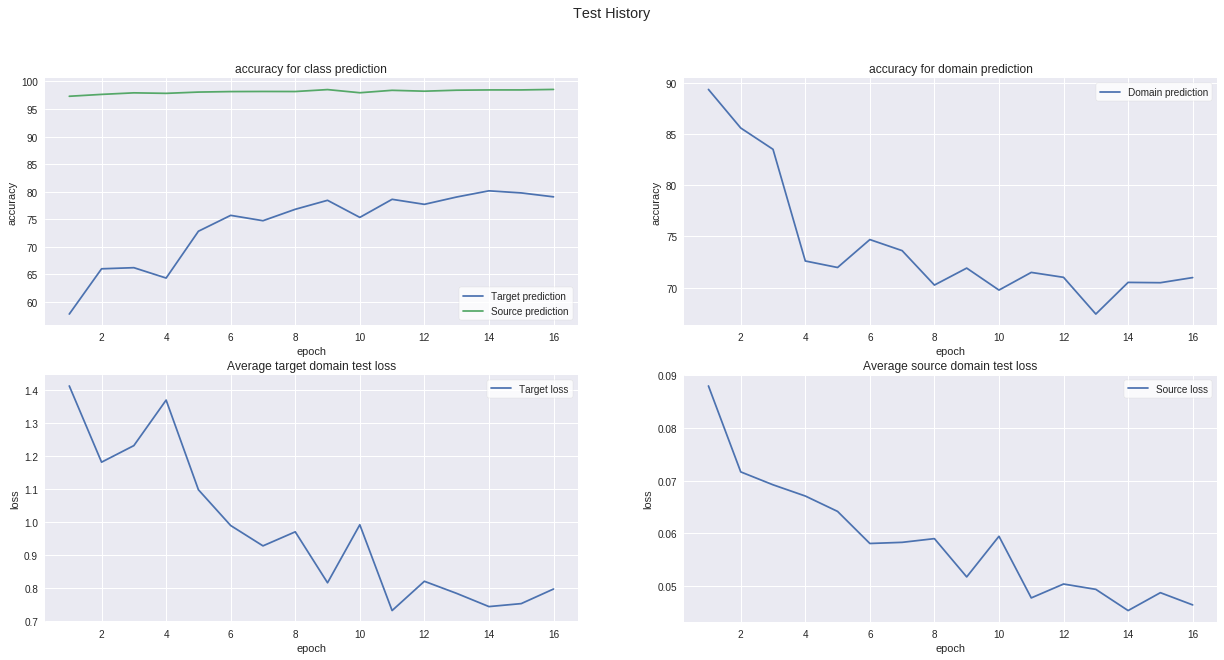

In [154]:
plots.plot_test(test_history5)